# Angle-based Joint and Individual Variation Explained  (AJIVE)

Adopted from the code at https://github.com/idc9/py_jive and tutorial written by:

Author: Iain Carmichael

License: MIT License

<blockquote>
    [1] Lock, Eric F., et al. “Joint and Individual Variation Explained (JIVE) for Integrated Analysis of Multiple Data Types.”        The Annals of Applied Statistics, vol. 7, no. 1, 2013, pp. 523–542., doi:10.1214/12-aoas597.
</blockquote>

--

AJIVE is a useful algorithm that decomposes multiple views of data into two main pieces
- Joint Variation
- Individual Variation

whose sum is the original data minus noise. This notebook will prove out the implementation of AJIVE and show some examples of the algorithm's usefulness

In [86]:
import numpy as np
from mvlearn.decomposition import AJIVE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Creation

Here we create data in the same way detailed in the initial JIVE paper:


The two views are created with shared joint variation, unique individual variation, and independent noise. A representation of what the implementation of this algorithm does can be seen in the cell below.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0047259X1730204X-gr1.jpg">


In [104]:
np.random.seed(12)

# First View
X1_joint = np.vstack([-1 * np.ones((10, 20)), np.ones((10, 20))])
X1_joint = np.hstack([np.zeros((20, 80)), X1_joint])
X1_indiv_t = np.vstack([
        np.ones((4, 50)),
        -1 * np.ones((4, 50)),
        np.zeros((4, 50)),
        np.ones((4, 50)),
        -1 * np.ones((4, 50)),
])
X1_indiv_b = np.vstack(
    [np.ones((5, 50)), -1 * np.ones((10, 50)), np.ones((5, 50))]
)
X1_indiv_tot = np.hstack([X1_indiv_t, X1_indiv_b])
X1_noise = np.random.normal(loc=0, scale=1, size=(20, 100))

# Second View
X2_joint = np.vstack([np.ones((10, 10)), -1 * np.ones((10, 10))])
X2_joint = 5000 * np.hstack([X2_joint, np.zeros((20, 10))])
X2_indiv = 5000 * np.vstack([
        -1 * np.ones((5, 20)),
        np.ones((5, 20)),
        -1 * np.ones((5, 20)),
        np.ones((5, 20)),
])
X2_noise = 5000 * np.random.normal(loc=0, scale=1, size=(20, 20))

# View Construction
X1 = X1_indiv_tot + X1_joint + X1_noise
X2 = X2_indiv + X2_joint + X2_noise

Xs_same = [V1, V1]
Xs_diff = [V1, V2]

## Scree Plots

Scree plots allow us to observe variation and determine an appropriate initial signal rank for each view.

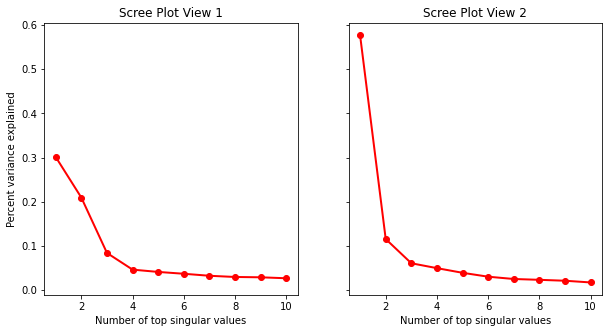

In [108]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
U, S, V = np.linalg.svd(X1)
vars1 = S**2 / np.sum(S**2)
U, S, V = np.linalg.svd(X2)
vars2 = S**2 / np.sum(S**2)
axes[0].plot(np.arange(10) + 1, vars1[:10], 'ro-', linewidth=2)
axes[1].plot(np.arange(10) + 1, vars2[:10], 'ro-', linewidth=2)
axes[0].set_title('Scree Plot View 1')
axes[1].set_title('Scree Plot View 2')
axes[0].set_xlabel('Number of top singular values')
axes[1].set_xlabel('Number of top singular values')
axes[0].set_ylabel('Percent variance explained')
plt.show()

Based on the scree plots, we fit AJIVE with both initial signal ranks set to 2.

In [109]:
ajive1 = AJIVE(init_signal_ranks=[2,2])
Js_1 = ajive1.fit_transform(Xs=[V1,V1])

ajive2 = AJIVE(init_signal_ranks=[2,2])
Js_2 = ajive2.fit_transform(Xs=[V1,V2])

## Heatmap Visualizations

Here we are using heatmaps to visualize the decomposition of our views. As we can see when we use two of the same views there is no Individualized Variation displayed. When we create two different views, the algorithm finds different decompositions where common and individual structural artifacts can be seen in their corresponding heatmaps.

In [110]:
def plot_blocks(blocks, names):
    n_views = len(blocks[0])
    n_blocks = len(blocks)
    for i in range(n_views):
        for j in range(n_blocks):
            plt.subplot(n_blocks, n_views, j*n_views+i+1)
            sns.heatmap(blocks[j][i], xticklabels=False, yticklabels=False, cmap="RdBu")
            plt.title(f"View {i}: {names[j]}")

### Same Views

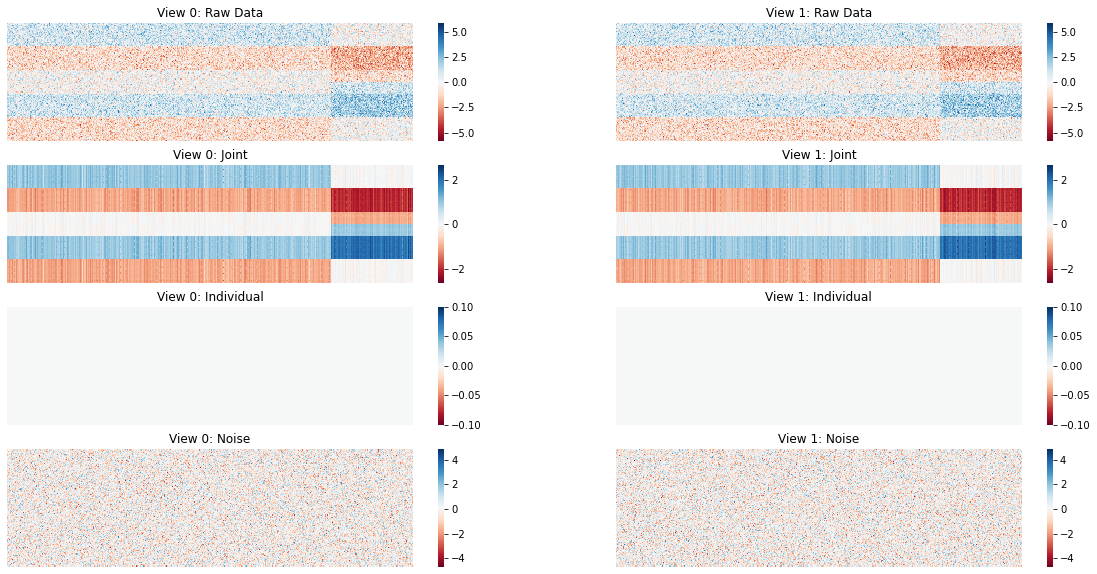

In [112]:
plt.figure(figsize=[20, 10])
residuals = [v1 - X for v1,X in zip(Views_1, ajive1.inverse_transform(Js_1))]
individual_mats = ajive1.individual_mats_
plot_blocks([Views_1, Js_1, individual_mats, residuals], ["Raw Data", "Joint", "Individual", "Noise"])

### Different Views

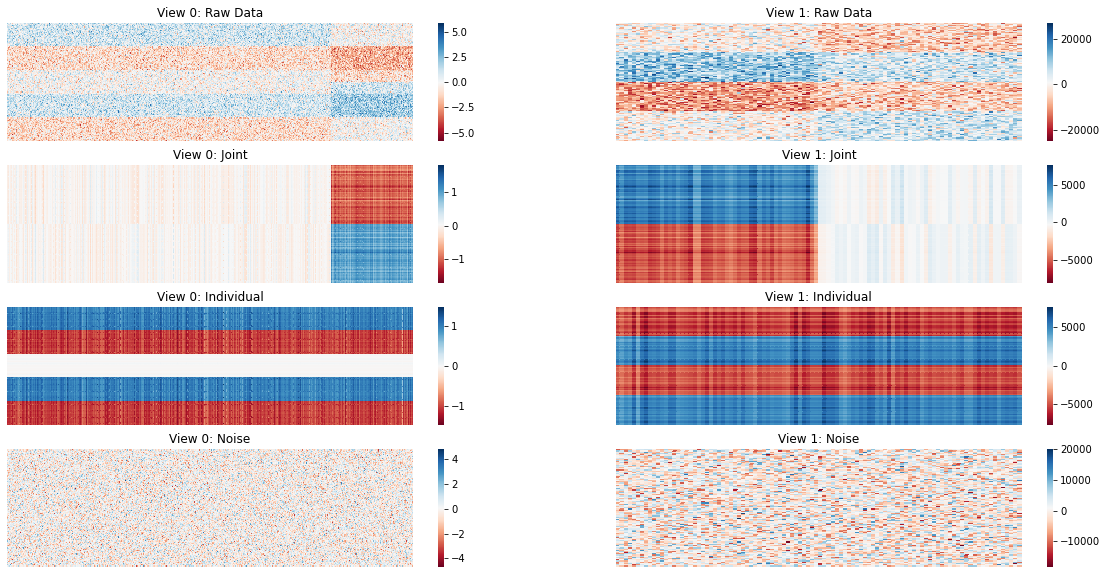

In [113]:
plt.figure(figsize=[20, 10])
plt.title('Different Views')
individual_mats = ajive2.individual_mats_
Xs_inv = ajive2.inverse_transform(Js_2)
residuals = [v - X for v, X in zip(Views_2, Xs_inv)]
plot_blocks([Views_2, Js_2, individual_mats, residuals], ["Raw Data", "Joint", "Individual", "Noise"])